In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Library imports
import torch
import matplotlib.pyplot as plt

In [2]:
# Import necessary utilities from my_small_PFN
from scripts.my_small_PFN import ModelConfig, MyRegressorPFN, BucketOps

# Create a default config
config = ModelConfig()

# Create a model using the default config
model = MyRegressorPFN(config)

In [3]:
# Set dimensions for dummy tests
B = 4
F = 24
train_size = 256
test_size = 128

# Create random dummy test tensors
X_train = torch.randn([B,train_size,F]) # (B, train_size, F)
X_test  = torch.randn([B, test_size,F]) # (B,  test_size, F)
y_train = torch.randn([B,train_size,1]) # (B, train_size, 1)
y_test  = torch.randn([B, test_size,1]) # (B,  test_size, 1)

# Obtain target labels from real line discretization
target = BucketOps.real_to_bucket(config.n_buckets, y_test).squeeze(-1) # (B, test_size)

# Flatten target to obtain labels (for nn.CrossEntropyLoss)
labels = target.reshape(-1) # (B * test_size)

# Sanity check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(target.shape, target.dtype)
print(labels.shape, labels.dtype)

torch.Size([4, 256, 24])
torch.Size([4, 128, 24])
torch.Size([4, 256, 1])
torch.Size([4, 128, 1])
torch.Size([4, 128]) torch.int64
torch.Size([512]) torch.int64


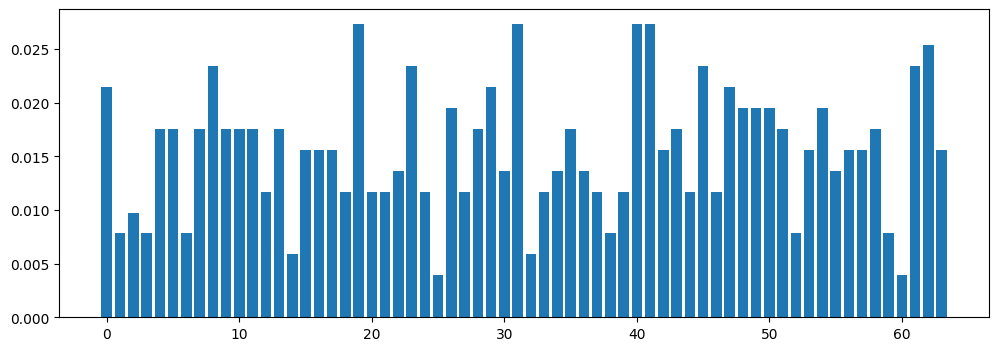

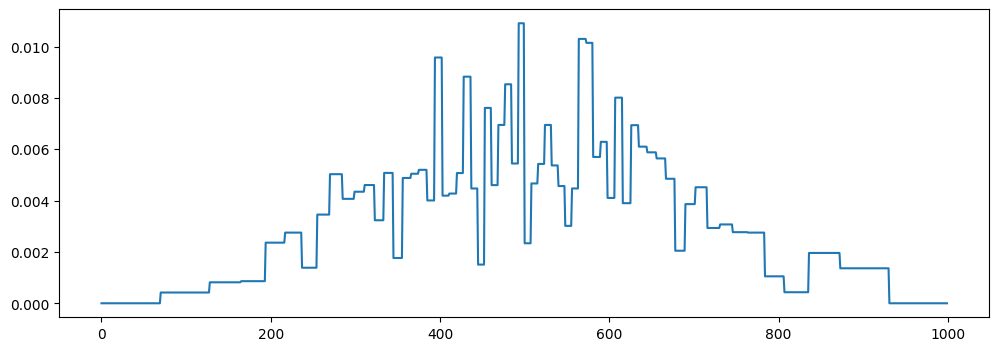

0.041634976863861084 1.024027705192566 1.0119426250457764
(0.04059405252337456, 1.0005459785461426, 1.0002729892730713)


In [4]:
# Study the labels distribution

# Count occurrences of each bucket
counts = torch.bincount(labels, minlength=config.n_buckets)
probs = counts / (B * test_size)

# Plot histogram
plt.figure(figsize=(12, 4))
plt.bar(range(config.n_buckets), probs.numpy())
plt.show()

# Plot distribution
plt.figure(figsize=(12, 4))
plt.plot(BucketOps.probs_to_distribution_plot(probs, torch.arange(0,1000)/200-2.5))
plt.show()

# Print original and approximated values
print(y_test.flatten().mean().item(),y_test.flatten().var().item(),y_test.flatten().std().item())
print(BucketOps.probs_to_mean_var_std(probs))

torch.Size([4, 128, 64])


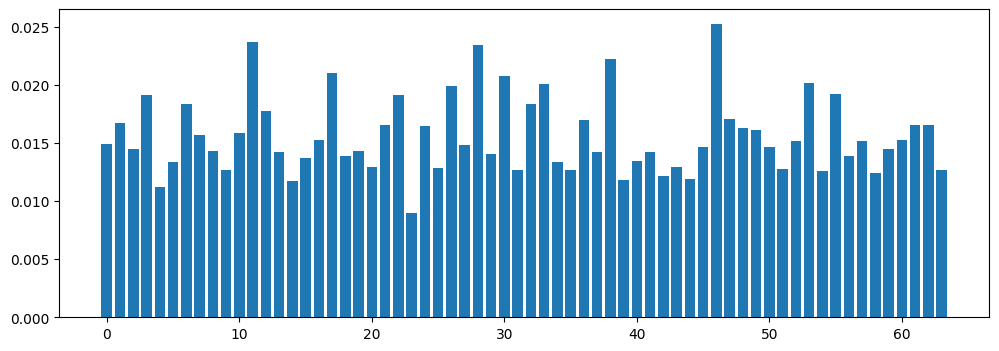

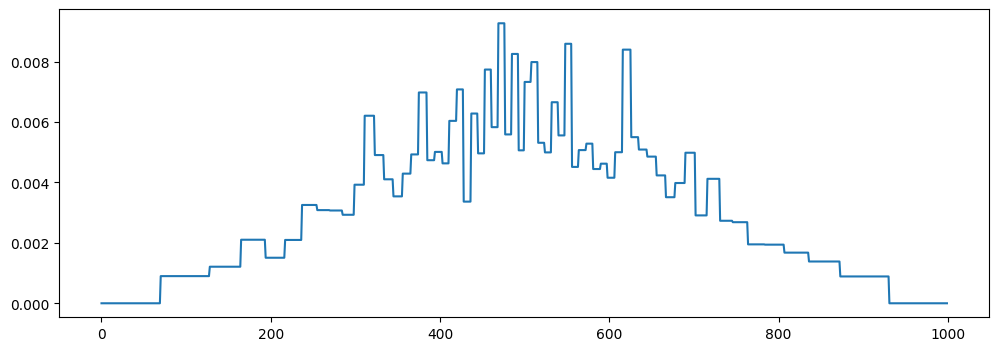

(-0.009111449122428894, 0.9747639894485474, 0.9873013496398926)


In [5]:
# Set the model to train mode
model.train()

# Call fit and predict to do an entire forward pass
model_out = model.fit(X_train, y_train).predict(X_test, output='logits')
print(model_out.shape)

# Obtain probabilities by applying softmax to logits
probs = torch.softmax(model_out[0,0], dim=0).cpu().detach()

# Study output to make sure it matches target distribution ~N(0,1), it does!

# Plot histogram
plt.figure(figsize=(12, 4))
plt.bar(range(config.n_buckets), probs)
plt.show()

# Plot distribution
plt.figure(figsize=(12, 4))
plt.plot(BucketOps.probs_to_distribution_plot(probs, torch.arange(0,1000)/200-2.5))
plt.show()

# Print approximated values
print(BucketOps.probs_to_mean_var_std(probs))

In [6]:
# Perform backwards to make sure it does not crash, it doesn't!

# Create loss function
loss_f = torch.nn.CrossEntropyLoss()

# Flatten for loss function
logits = model_out.reshape(-1, model_out.shape[-1]) # (B, T, C) → (B*T, C)
print(logits.shape)

# Calculate loss
loss = loss_f(logits, labels.to(logits.device))
print(loss)

# Do backward pass
loss.backward()
print("Backward pass succeeded!")

torch.Size([512, 64])
tensor(4.1996, device='cuda:0', grad_fn=<NllLossBackward0>)
Backward pass succeeded!
